In [1]:
from datasets import load_dataset
from itertools import islice
import pandas as pd
from IPython.display import Audio
import soundfile as sf
import tempfile
from IPython.display import Audio, display

# Load the dataset splits
train_dataset = load_dataset("facebook/voxpopuli", "en", split="train", trust_remote_code=True,streaming='True')
test_dataset = load_dataset("facebook/voxpopuli", "en", split="test", trust_remote_code=True,streaming='True')
validation_dataset = load_dataset("facebook/voxpopuli", "en", split="validation", trust_remote_code=True,streaming='True')

# Extract 100 samples from each split using islice
train_sample = list(islice(train_dataset, 50))
test_sample = list(islice(test_dataset, 30))
validation_sample = list(islice(validation_dataset, 30))

# Print a sample from each
print("Train Sample:", train_sample[0])
print("Test Sample:", test_sample[0])
print("Validation Sample:", validation_sample[0])


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

Train Sample: {'audio_id': '20180418-0900-PLENARY-3-en_20180418-08:50:36_17', 'language': 0, 'audio': {'path': 'train_part_0/20180418-0900-PLENARY-3-en_20180418-08:50:36_17.wav', 'array': array([-0.00030518,  0.00119019,  0.00506592, ..., -0.00036621,
       -0.00027466, -0.00018311]), 'sampling_rate': 16000}, 'raw_text': 'If you do not address this problem, the ground is there for populist nationalist forces to go on growing all over Europe.', 'normalized_text': 'if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe.', 'gender': 'female', 'speaker_id': '124737', 'is_gold_transcript': True, 'accent': 'None'}
Test Sample: {'audio_id': '20170703-0900-PLENARY-26-en_20170703-22:30:55_4', 'language': 0, 'audio': {'path': 'test_part_0/20170703-0900-PLENARY-26-en_20170703-22:30:55_4.wav', 'array': array([0.00170898, 0.00491333, 0.00326538, ..., 0.00048828, 0.00161743,
       0.00204468]), 'sampling_rate': 16000}, 'raw_text': 'I

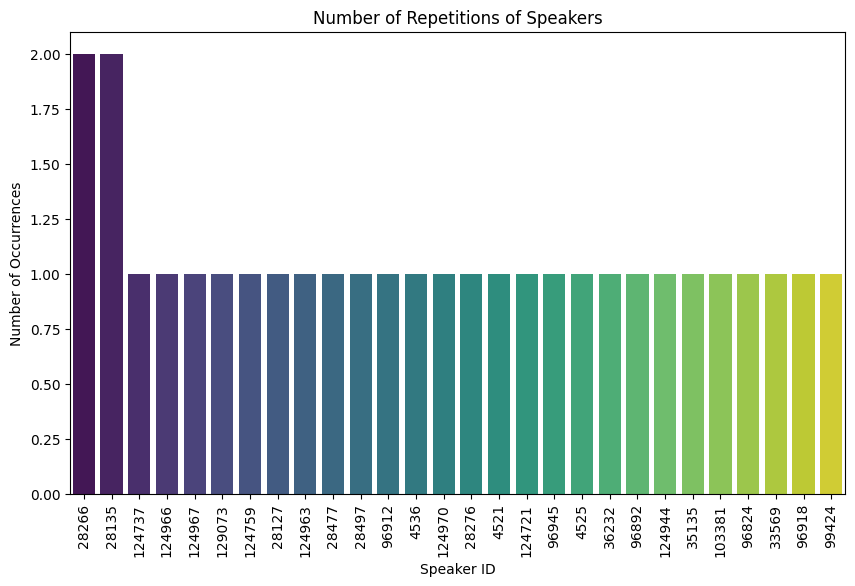

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_sample is a list of dictionaries
train_sample = [
    sample for sample in train_sample
    if sample.get("speaker_id") not in (None, "None", "")  # Handle explicit None, empty strings, or string "None"
]

# Extract 'speaker_id' from the train_sample (assuming speaker_id exists in the sample)
speaker_ids = [sample["speaker_id"] for sample in train_sample]



# Count the occurrences of each speaker_id
speaker_counts = pd.Series(speaker_ids).value_counts()

# Cap the number of repetitions for each speaker to 200
capped_speaker_counts = speaker_counts.clip(upper=200)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=capped_speaker_counts.index, y=capped_speaker_counts.values, palette='viridis')
plt.title('Number of Repetitions of Speakers')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [3]:


train_data = [{"audio": sample["audio"], "normalized_text": sample["normalized_text"]} for sample in train_sample]
val_data = [{"audio": sample["audio"], "normalized_text": sample["normalized_text"]} for sample in validation_sample]
test_data = [{"audio": sample["audio"], "normalized_text": sample["normalized_text"]} for sample in test_sample]

train_df=pd.DataFrame(train_data)
val_df=pd.DataFrame(val_data)
test_df=pd.DataFrame(test_data)
print(train_df.head())

                                               audio  \
0  {'path': 'train_part_0/20180418-0900-PLENARY-3...   
1  {'path': 'train_part_0/20170614-0900-PLENARY-5...   
2  {'path': 'train_part_0/20160413-0900-PLENARY-1...   
3  {'path': 'train_part_0/20170215-0900-PLENARY-4...   
4  {'path': 'train_part_0/20150225-0900-PLENARY-9...   

                                     normalized_text  
0  if you do not address this problem the ground ...  
1  they attacked and removed the voices of resist...  
2              these are not easy issues to resolve.  
3                              so it is a good deal.  
4  the eu has not so much kicked the can down the...  


In [4]:


# Get the audio data and sampling rate
sample=train_df.iloc[0]
audio_data = sample['audio']['array']
sampling_rate = sample['audio']['sampling_rate']

# Save the audio to a temporary WAV file
with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as temp_file:
    sf.write(temp_file.name, audio_data, sampling_rate)
    temp_file_path = temp_file.name

# Play the audio from the temporary file
display(Audio(temp_file_path))


In [5]:
import re

# Function to clean text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Replace unsupported characters with spaces or remove them
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    
    # Replace any punctuation (you can modify this depending on the use case)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove non-alphanumeric characters
    
    # Remove extra spaces (including leading/trailing spaces)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the 'normalized_text' column
train_df['cleaned_text'] = train_df['normalized_text'].apply(clean_text)
val_df['cleaned_text'] = val_df['normalized_text'].apply(clean_text)
test_df['cleaned_text'] = test_df['normalized_text'].apply(clean_text)

print(train_df[['normalized_text', 'cleaned_text']].head())

                                     normalized_text  \
0  if you do not address this problem the ground ...   
1  they attacked and removed the voices of resist...   
2              these are not easy issues to resolve.   
3                              so it is a good deal.   
4  the eu has not so much kicked the can down the...   

                                        cleaned_text  
0  if you do not address this problem the ground ...  
1  they attacked and removed the voices of resist...  
2               these are not easy issues to resolve  
3                               so it is a good deal  
4  the eu has not so much kicked the can down the...  


In [6]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
import os
import torch
!pip install datasets soundfile speechbrain
from speechbrain.pretrained import EncoderClassifier
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 13.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 38.6 MB/s eta 0:00:00


<ipython-input-6-e3ede53a3ced>:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [7]:


spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name, 
    run_opts={"device": device}, 
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings
    
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["cleaned_text"],
        audio_target=audio["array"], 
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [8]:
def process_row(row):
        return prepare_dataset(row)
processed_train_df = train_df.apply(process_row, axis=1)
processed_train_df = pd.DataFrame(processed_train_df.tolist())

processed_val_df = val_df.apply(process_row, axis=1)
processed_val_df = pd.DataFrame(processed_val_df.tolist())

processed_test_df = test_df.apply(process_row, axis=1)
processed_test_df = pd.DataFrame(processed_test_df.tolist())
print(f"Processed {len(processed_train_df)} examples successfully.")
print(processed_train_df[:2])  # Display the first two processed examples


Processed 30 examples successfully.
                                           input_ids  \
0  [4, 10, 19, 4, 22, 8, 16, 4, 14, 8, 4, 9, 8, 6...   
1  [4, 6, 11, 5, 22, 4, 7, 6, 6, 7, 17, 28, 5, 14...   

                                              labels  \
0  [[-3.5011022, -3.0900385, -3.2359655, -3.08114...   
1  [[-3.8801012, -3.3910449, -2.9725516, -3.15376...   

                                  speaker_embeddings  
0  [-0.065517835, -0.009306857, 0.026587171, 0.02...  
1  [-0.06098693, 0.058039337, 0.016364831, 0.0199...  


In [9]:
print("Shape of speaker_embeddings in DataFrame:", processed_train_df["speaker_embeddings"].iloc[0].shape)
print("Shape of speaker_embeddings in DataFrame:", processed_val_df["speaker_embeddings"].iloc[0].shape)
print("Shape of speaker_embeddings in DataFrame:", processed_test_df["speaker_embeddings"].iloc[0].shape)


Shape of speaker_embeddings in DataFrame: (512,)
Shape of speaker_embeddings in DataFrame: (512,)
Shape of speaker_embeddings in DataFrame: (512,)


In [10]:
def is_not_too_long(input_ids):
    return len(input_ids) < 300
filtered_train_df = processed_train_df[processed_train_df["input_ids"].apply(is_not_too_long)]
filtered_val_df = processed_val_df[processed_val_df["input_ids"].apply(is_not_too_long)]
filtered_test_df = processed_test_df[processed_test_df["input_ids"].apply(is_not_too_long)]

In [11]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
spectrogram = torch.tensor(processed_train_df["labels"].iloc[0])
tokenizer=processor.tokenizer
print(tokenizer.decode(processed_train_df["input_ids"].iloc[0]))
with torch.no_grad():
    speech = vocoder(spectrogram)
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

if you do not address this problem the ground is there for populist nationalist forces to go on growing all over europe</s>


In [12]:
from typing import Any, Dict, List, Union
import torch
import numpy as np
class batch_creation:
    def __init__(self, processor: Any):
        self.processor = processor

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )        

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        speaker_features_np = np.array(speaker_features)
        batch["speaker_embeddings"] = torch.tensor(speaker_features_np)

        return batch
from torch.utils.data import Dataset
import torch

class TTSDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        example = self.df.iloc[idx]
        
        # Create the example dictionary for each row in the dataframe
        example_dict = {
            "input_ids": example["input_ids"],  # or your column for tokenized input
            "labels": example["labels"],  # or your column for audio targets
            "speaker_embeddings": example["speaker_embeddings"],  # precomputed speaker embeddings
        }
        
        return example_dict

train_dataset = TTSDataset(filtered_train_df, processor)
val_dataset = TTSDataset(filtered_val_df, processor)
test_dataset = TTSDataset(filtered_test_df, processor)

data_collator = batch_creation(processor)

In [13]:
from transformers import Seq2SeqTrainingArguments,Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=100,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=32,
    save_steps=500,
    eval_steps=500,
    logging_steps=50,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
    dataloader_num_workers=4 

)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Begin training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_re

Step,Training Loss,Validation Loss
500,0.468800,0.569429


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}


TrainOutput(global_step=500, training_loss=0.5233470344543457, metrics={'train_runtime': 1445.8129, 'train_samples_per_second': 22.133, 'train_steps_per_second': 0.346, 'total_flos': 3504216226896000.0, 'train_loss': 0.5233470344543457, 'epoch': 500.0})

In [40]:
model = SpeechT5ForTextToSpeech.from_pretrained("/kaggle/working/speecht5_tts_voxpopuli_nl/checkpoint-500")
example = train_dataset[3]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape
text = "hello mister zed"
inputs = processor(text=text, return_tensors="pt")
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad():
    speech = vocoder(spectrogram)
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)


In [64]:
import torch

# Extract speaker embeddings
example = train_dataset[3]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
torch.save(speaker_embeddings, 'speaker_embeddings.pt')
import shutil
shutil.move('speaker_embeddings.pt', '/kaggle/working/speaker_embeddings.pt')
print(speaker_embeddings.shape)


torch.Size([1, 512])


In [38]:
import shutil

# Create a zip file of the model folder
shutil.make_archive("/kaggle/working/speecht5_tts_voxpopuli_nl_checkpoint", 'zip', "/kaggle/working/speecht5_tts_voxpopuli_nl", "checkpoint-500")


'/kaggle/working/speecht5_tts_voxpopuli_nl_checkpoint.zip'

In [63]:
from IPython.display import FileLink

file_path = '/kaggle/working/speaker_embeddings.pt'
FileLink(file_path)

/kaggle/working/speaker_embeddings.pt